In [2]:
import cv2
import os
import numpy as np
import pandas as pd
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import logging

## Imputation
from sklearn.impute import SimpleImputer, KNNImputer

## Feature-scaling stack
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, OneHotEncoder, FunctionTransformer

## Dimesionality reduction
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

## Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN

## Machine-learning stack
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier 
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

## Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score, auc, fbeta_score, f1_score

## Model saving
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

# Evaluation Functions

In [3]:
def partial_auc_score(y_actual, y_scores, tpr_threshold=0.80):
    max_fpr = 1 - tpr_threshold

    # create numpy arrays
    y_actual = np.asarray(y_actual)
    y_scores = np.asarray(y_scores)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_actual, y_scores)

    # Find the index where fpr exceeds max_fpr
    stop_index = np.searchsorted(fpr, max_fpr, side='right')

    if stop_index < len(fpr):
        # Interpolate to find the TPR at max_fpr
        fpr_interp_points = [fpr[stop_index - 1], fpr[stop_index]]
        tpr_interp_points = [tpr[stop_index - 1], tpr[stop_index]]
        tpr = np.append(tpr[:stop_index], np.interp(max_fpr, fpr_interp_points, tpr_interp_points))
        fpr = np.append(fpr[:stop_index], max_fpr)
    else:
        tpr = np.append(tpr, 1.0)
        fpr = np.append(fpr, max_fpr)

    # Calculate partial AUC
    partial_auc_value = auc(fpr, tpr)

    return partial_auc_value
    
def predict_and_print_scores(model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,                             
                             training=True,
                             test=True,
                             accuracy=True,
                             recall=True,
                             precision=True,
                             fbeta=[True, 1.0],
                             roc_auc=True,
                             pauc=True,
                             matrix=True,
                             figsize=(3,2),
                             cmap='YlGn'):
    
    '''
    Given an already trained model, this function predicts and print some performance scores training and/or testing data.
    The supported metrics are: accuracy, recall, precision, fbeta_score (and f1_score if beta = 1.0), roc_auc.
    If the input parameter "matrix" is set to True, the function plot the confusion matrix with a color map given in "cmap".

    model             Trained model
    X_train           Training data with features
    y_train           Training data with labels or targets
    X_test            Testing data with features
    y_test            Testing data with labels or targets                             
    training=True     True: print scores on the training set
    test=True         True: print scores on the testing set
    accuracy=True     True: print accuracy_score()
    recall=True       True: print recall_score()
    precision=True    True: print precision_score()
    fbeta=[True, 1.0] [True, beta]: print fbeta_score. If beta = 1.0: f1_score
    roc_auc=True      True: print roc_auc_score()
    matrix=True       True: plot confusion matrix
    figsize=(3,2)     Figure size for the confusion matrix
    cmap='YlGn')      Color map for the confusion matrix
    
    Possible color maps: 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                        'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                        'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
    
    Returns: fig, ax: the figure objects of the cunfusion matrix (if enabled)
    '''

    # Prediction
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
            
    # Scores
    if accuracy:
        if training:
            print("Accuracy on training set:", round(accuracy_score(y_train, y_pred_train), 2))
        if test:
            print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_test), 2))
        print("--------"*5)
    
    if recall:        
        if training:
            print("Recall on training set:", round(recall_score(y_train, y_pred_train), 2))
        if test:
            print("Recall on test set:", round(recall_score(y_test, y_pred_test), 2))
        print("--------"*5)
    
    if precision:
        if training:
            print("Precision on training set:", round(precision_score(y_train, y_pred_train), 2))
        if test:
            print("Precision on test set:", round(precision_score(y_test, y_pred_test), 2))
        print("--------"*5)

    if fbeta[0]:
        if training:
            print("fbeta_score on training set:", round(fbeta_score(y_train, y_pred_train, beta=fbeta[1]), 2))
        if test:
            print("fbeta_score on test set:", round(fbeta_score(y_test, y_pred_test, beta=fbeta[1]), 2))
        print("--------"*5)

    if roc_auc:
        y_pred_train_p = model.predict_proba(X_train)[:,1]
        y_pred_test_p = model.predict_proba(X_test)[:,1]
        if training:
            print('roc_auc_score on trainig set: ', round(roc_auc_score(y_train, y_pred_train_p), 2))
        if test:
            print('roc_auc_score on test set: ', round(roc_auc_score(y_test, y_pred_test_p), 2))
        print("--------"*5)
        
    if pauc:
        y_pred_train_p = model.predict_proba(X_train)[:,1]
        y_pred_test_p = model.predict_proba(X_test)[:,1]
        if training:
            print('pAUC on trainig set: ', round(partial_auc_score(y_train, y_pred_train_p), 4))
        if test:
            print('pAUC on test set: ', round(partial_auc_score(y_test, y_pred_test_p), 4))
        print("--------"*5)
        
    # Plot confusion matrix 
    if matrix:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
        sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap=cmap);
        plt.title('Test Set')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')                 
        
def train_crossval_predict_score(model,
                                 hyperparams,
                                 X_train,
                                 y_train,
                                 X_test,
                                 y_test,
                                 cv=5,
                                 scoring='accuracy',
                                 verbose=0,
                                 n_jobs=-1,
                                 cross_val='full',
                                 n_iter=100,
                                 random_state='None',
                                 training=True,
                                 test=True,
                                 accuracy=True,
                                 recall=True,
                                 precision=True,
                                 fbeta=[True, 1.0],
                                 roc_auc=True,
                                 pauc=True,
                                 matrix=True,
                                 figsize=(3,2),
                                 cmap='YlGn'):
                                 
    '''
    Given an instantiated model, this function trains, cross-validate, predicts, and prints some performance scores training and/or testing data.
    The cross-validation strategy is selected with the input parameters "cross_val".
    The supported metrics are: accuracy, recall, precision, fbeta_score (and f1_score if beta = 1.0), roc_auc.
    If the input parameter "matrix" is set to True, the function plot the confusion matrix with a color map given in "cmap".

    model                 #Instantiated model
    hyperparams           #Dictionary including hyperparameters
    X_train               #Training data with features
    y_train               #Training data with labels or targets
    X_test                #Testing data with features
    y_test                #Testing data with labels or targets
    cv=5                  #Number of cross-validation folds
    scoring='accuracy'    #Scoring method
    verbose=0             #Verbose
    n_jobs=-1             #Number of jobs in parallel
    cross_val='full'      #'Full'/'full': Apply GridSearchCV. 'Random'/'random': Apply RandomSearchCV
    n_iter=100,           #Number of iterations for RandomSearchCV (unused for full search)
    random_state          #Random state parameter for RandomSearchCV: 'None' or an integer
    training=True         #True: print scores on the training set
    test=True             #True: print scores on the testing set
    accuracy=True         #True: print accuracy_score()
    recall=True           #True: print recall_score()
    precision=True        #True: print precision_score()
    fbeta=[True, 1.0]     #[True, beta]: print fbeta_score. If beta = 1.0: f1_score
    roc_auc=True          #True: print roc_auc_score()
    matrix=True           #True: plot confusion matrix
    figsize=(3,2)         #Figure size for the confusion matrix
    cmap='YlGn'):         #Color map for the confusion matrix

    Possible color maps: 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                        'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                        'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
    
    Returns:
    - best_model: object of the best model after cross-validation
    - best_params: hyperparameters of the best model
    - fig, ax: the figure objects of the confusion matrix (if enabled)
'''

    # Cross-validation
    if cross_val == 'Full' or cross_val == 'full':
        grid_model = GridSearchCV(model, param_grid=hyperparams, cv=cv, scoring=scoring, verbose=verbose, n_jobs=n_jobs)
    elif cross_val == 'Random' or cross_val == 'random':        
        grid_model = RandomizedSearchCV(model, param_distributions=hyperparams, n_iter=n_iter, cv=cv, scoring=scoring, random_state=random_state, verbose=verbose, n_jobs=n_jobs)
        
    # Fit
    grid_model.fit(X_train, y_train)
    best_model = grid_model.best_estimator_
    best_params = grid_model.best_params_
    print('Best params:', grid_model.best_params_)
    print("--------"*5)
    
    # Predict and print results
    predict_and_print_scores(best_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             training=training,
                             test=test,
                             accuracy=accuracy,
                             recall=recall,
                             precision=precision,
                             fbeta=fbeta,
                             roc_auc=roc_auc,
                             pauc=pauc,
                             matrix=matrix,
                             figsize=figsize,
                             cmap=cmap)
    
    return best_model, best_params

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges,
                          figsize=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # Confusion matrix
    #cm = confusion_matrix(test_labels, rf_predictions)
    #plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
    #                      title = 'Health Confusion Matrix')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    # Plot the confusion matrix
    plt.figure(figsize = figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    #plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Model Loading

In [4]:
# Read the dataset
ROOT_DATASET_DIR = "./"
file_name = os.path.join(ROOT_DATASET_DIR,"train-metadata-eda-fe.csv")
df = pd.read_csv(file_name)

# Exploratory Data Analysis (EDA)

In [5]:
df.drop(columns=['isic_id'], inplace=True)
df['anatom_site_general'] = pd.Categorical(df['anatom_site_general'])
df['tbp_lv_location'] = pd.Categorical(df['tbp_lv_location'])
df['tbp_lv_location_simple'] = pd.Categorical(df['tbp_lv_location_simple'])
df['sex'] = pd.Categorical(df['sex'])

In [6]:
df.dtypes

target                               int64
age_approx                         float64
sex                               category
anatom_site_general               category
clin_size_long_diam_mm             float64
                                    ...   
sqrt_hue_color_std_interaction     float64
sqrt_normalized_lesion_size        float64
sqrt_color_variance_ratio          float64
sqrt_color_asymmetry_index         float64
sqrt_shape_color_consistency       float64
Length: 128, dtype: object

# Feature Preparation

In [7]:
# Original feature names
features_to_be_logtr = ['clin_size_long_diam_mm',
                        'tbp_lv_areaMM2',
                        'tbp_lv_area_perim_ratio',
                        'tbp_lv_color_std_mean',
                        'tbp_lv_deltaLB',
                        'tbp_lv_deltaLBnorm',
                        'tbp_lv_minorAxisMM',
                        'tbp_lv_norm_border',
                        'tbp_lv_norm_color',
                        'tbp_lv_perimeterMM',
                        'tbp_lv_radial_color_std_max',
                        'tbp_lv_stdL',
                        'tbp_lv_stdLExt',
                        'tbp_lv_symm_2axis']
features_to_be_sqrtr = ['tbp_lv_eccentricity']

# Modified original feature names
log_features = ['log_' + col for col in features_to_be_logtr]
sqr_features = ['sqr_' + col for col in features_to_be_sqrtr]

# New feature names
new_features_to_be_logtr = ['hue_contrast',
                            'luminance_contrast',
                            'lesion_color_difference',
                            'border_complexity',
                            #'color_uniformity',
                            'perimeter_to_area_ratio',
                            'area_to_perimeter_ratio',
                            'lesion_visibility_score',
                            'symmetry_border_consistency',
                            'consistency_symmetry_border',
                            #'color_consistency',
                            'consistency_color',
                            'size_age_interaction',
                            'lesion_severity_index',
                            'shape_complexity_index',
                            #'normalized_lesion_size',
                            'std_dev_contrast',
                            'color_shape_composite_index',
                            'symmetry_perimeter_interaction',
                            'comprehensive_lesion_index',
                            #'color_variance_ratio',
                            'border_color_interaction',
                            'size_color_contrast_ratio',
                            'age_normalized_nevi_confidence',
                            #'color_asymmetry_index',
                            'volume_approximation_3d',
                            'color_range',
                            #'shape_color_consistency',
                            'age_size_symmetry_index',
                            'index_age_size_symmetry']
new_features_to_be_sqrtr = ['lesion_shape_index',
                            'position_distance_3d']
new_features_to_be_sqrttr = ['color_consistency',
                             'hue_color_std_interaction',
                             'normalized_lesion_size',
                            #'overall_color_difference',
                             'color_variance_ratio',
                             'color_asymmetry_index',
                             'shape_color_consistency']

# Modify the column names
log_new_features = ['log_' + col for col in new_features_to_be_logtr]
sqr_new_features = ['sqr_' + col for col in new_features_to_be_sqrtr]
sqrt_new_features = ['sqrt_' + col for col in new_features_to_be_sqrttr]

# Train-test Split

In [8]:
# Train-Test split
# Drop non-used features for the baseline + target
X1 = df.drop(['target']
             + features_to_be_logtr + features_to_be_sqrtr                                         # drop original features with skeweness (no transformation)                          
             + new_features_to_be_logtr + new_features_to_be_sqrtr + new_features_to_be_sqrttr,    # drop new features with skeweness (no transformation)             
             axis=1)
y = df['target']
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
numerical_features = X1.select_dtypes(include=['float64','int64']).columns.tolist()
categorical_features = X1.select_dtypes(include=['category']).columns.tolist()
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

Numerical features: ['age_approx', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_nevi_confidence', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'log_clin_size_long_diam_mm', 'log_tbp_lv_areaMM2', 'log_tbp_lv_area_perim_ratio', 'log_tbp_lv_color_std_mean', 'log_tbp_lv_deltaLB', 'log_tbp_lv_deltaLBnorm', 'log_tbp_lv_minorAxisMM', 'log_tbp_lv_norm_border', 'log_tbp_lv_norm_color', 'log_tbp_lv_perimeterMM', 'log_tbp_lv_radial_color_std_max', 'log_tbp_lv_stdL', 'log_tbp_lv_stdLExt', 'log_tbp_lv_symm_2axis', 'sqr_tbp_lv_eccentricity', 'lesion_size_ratio', 'color_contrast_index', 'log_lesion_area', 'mean_hue_difference', 'lesion_orientation_3d', 'overall_color_difference', 'border_color_interaction_2', 'age_normalized_nevi_confidence_2', 'border_length_ratio', 'log_hue_contrast', 'log_luminance_contrast', 'log_le

# Dimensionality Reduction

In [10]:
# Dimensionality reduction

# Use SelectKBest for numerical features
Kbest_numerical = SelectKBest(score_func=f_classif, k='all')
Kbest_numerical.fit(X1_train[numerical_features], y_train)

# Extract feature scores and p-values
scores = Kbest_numerical.scores_
pvalues = Kbest_numerical.pvalues_

# Create a DataFrame to hold feature names, scores, and p-values
feature_scores = pd.DataFrame({
    'Feature': numerical_features,
    'Score': scores,
    'P-Value': pvalues
})

# Sort features by their scores
best_feature_scores = feature_scores[feature_scores['P-Value'] < 0.05]
sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)

# Display the sorted features
KBEST_NUM = sorted_features.shape[0]
print(f"Number of relevant numerical features: {KBEST_NUM}\n")
print(sorted_features.set_index('Feature'))

# Use SelectKBest for categorical features
# Build a pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

pipeline = Pipeline(steps=[
    ('onehot', preprocessor),
    ('kbest', SelectKBest(score_func=chi2, k='all'))
])

cat_transformed = pipeline.fit_transform(X1_train, y_train)
Kbest_categorical = pipeline.named_steps['kbest']

# Extract feature scores and p-values
scores = Kbest_categorical.scores_
pvalues = Kbest_categorical.pvalues_

# Extract feature names after one-hot encoding
one_hot_feature_names = pipeline.named_steps['onehot'].transformers_[0][1].get_feature_names_out(categorical_features)

# Create a DataFrame to hold feature names, scores, and p-values
feature_scores = pd.DataFrame({
    'Feature': one_hot_feature_names,
    'Score': scores,
    'P-Value': pvalues
})

# Sort features by their scores
best_feature_scores = feature_scores[feature_scores['P-Value'] < 0.05]
sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)

# Display the sorted features
KBEST_CAT = sorted_features.shape[0]
print(f"Number of relevant categorical features: {KBEST_CAT}\n")
print(sorted_features.set_index('Feature'))

Number of relevant numerical features: 68

                                      Score        P-Value
Feature                                                   
tbp_lv_H                         596.935096  1.030472e-131
mean_hue_difference              516.167671  3.564907e-114
tbp_lv_deltaB                    385.672387   8.152815e-86
tbp_lv_Hext                      332.404923   3.141478e-74
overall_color_difference         299.873400   3.770619e-67
...                                     ...            ...
sqrt_hue_color_std_interaction     7.667604   5.622435e-03
log_symmetry_border_consistency    5.745972   1.652708e-02
tbp_lv_L                           4.604228   3.189396e-02
tbp_lv_x                           4.396313   3.601751e-02
lesion_orientation_3d              4.292523   3.828112e-02

[68 rows x 2 columns]
Number of relevant categorical features: 8

                                              Score       P-Value
Feature                                                  

# Baseline Model with Feature Engineering

In [ ]:
# Define the objective function
#def objective(trial):
#
#    start_time = time.time()
#
#    # Suggest values for the hyperparameters
#    #penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
#    C = trial.suggest_float('C', 1.0, 25.0)
#    #solver = trial.suggest_categorical('solver', ['liblinear', 'saga']) #, 'lbfgs', 'newton-cholesky'])    
#    
#    # Create the model with these hyperparameters
#    # Pipeline
#    pipe_num = Pipeline([
#        ('scaler', RobustScaler()),
#        ('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)),   #From Kbest with a 5% threshold 68 features are obtained
#    ])
#
#    pipe_cat = Pipeline([
#        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
#        ('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)),    
#    ])
#
#    preprocessing_lr = ColumnTransformer(transformers=[
#        ('numerical', pipe_num, numerical_features),
#        ('categorical',pipe_cat, categorical_features)
#     ])
#                               
#    pipe_lr = ImbPipeline([
#        ('features', preprocessing_lr),  
#        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
#        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
#        ('LR', LogisticRegression(max_iter=1000,
#                                  penalty='l1',
#                                  C=C,
#                                  solver='liblinear',        
#                                  random_state=42))
#])
#
#    print(f"Trial {trial.number}: C={C}")
#    
#    # Train the model
#    pipe_lr.fit(X1_train, y_train)
#    
#    # Predict on the validation set
#    preds = pipe_lr.predict_proba(X1_test)[:1]
#    
#    # Calculate accuracy
#    pauc = partial_auc_score(y_test, preds)
#
#    end_time = time.time()
#    elapsed_time = end_time - start_time
#    print(f"Trial {trial.number} completed in {elapsed_time:.2f} seconds. partial AUC={pauc}")
#
#    # We want to maximize accuracy, so return it as a negative value
#    return pauc
#
## Create a study object and specify the direction of optimization
#study = optuna.create_study(direction='maximize')
#
## Start the optimization
#study.optimize(objective, n_trials=50, n_jobs=1)  # n_trials is the number of trials, n_jobs=-1 uses all CPUs
#
## Get the best trial
#best_trial = study.best_trial
#
#print(f'Best trial number: {best_trial.number}')
#print(f'Best value (accuracy): {best_trial.value}')
#print(f'Best hyperparameters: {best_trial.params}')

# WITHOUT OPTUNA
# Best params: {'LR__C': 10, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
#pAUC on trainig set:  0.1583
#pAUC on test set:  0.1481

[I 2024-08-19 18:50:08,660] A new study created in memory with name: no-name-54f0ee40-068c-4568-80ca-f2ec936ccb62


Trial 0: C=21.207477961252266


# Balanced Random Forest with Optuna

In [42]:
# Define the objective function
def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500) #200-400
    max_depth = trial.suggest_int('max_depth', 10, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 7) #2-5
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5) #1-2   
    
    # Create the model with these hyperparameters
    # Pipeline
    pipe_num = Pipeline([
        ('scaler', RobustScaler()),
        ('kbest', SelectKBest(score_func=f_classif, k=68)),   
    ])

    pipe_cat = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
        ('kbest', SelectKBest(score_func=chi2, k=8)),    
    ])

    preprocessing_rf = ColumnTransformer(transformers=[
        ('numerical', pipe_num, numerical_features),
        ('categorical',pipe_cat, categorical_features)
     ])
                               
    pipe_rf = ImbPipeline([
        ('features', preprocessing_rf),  
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
        ('RF', BalancedRandomForestClassifier(random_state=42,
                                              n_estimators=n_estimators,
                                              max_depth=max_depth,
                                              min_samples_split=min_samples_split,
                                              min_samples_leaf=min_samples_leaf,
                                              bootstrap=True,
                                              class_weight='balanced_subsample'
                                             )
        )
])

    # Train the model
    pipe_rf.fit(X1_train, y_train)
    
    # Predict on the validation set
    preds = pipe_rf.predict_proba(X1_test)[:,1]
    
    # Calculate accuracy
    pauc = partial_auc_score(y_test, preds)
    
    # We want to maximize accuracy, so return it as a negative value
    return pauc

# Create a study object and specify the direction of optimization
study = optuna.create_study(direction='maximize')

# Start the optimization
study.optimize(objective, n_trials=500, n_jobs=-1)  # n_trials is the number of trials, n_jobs=-1 uses all CPUs

# Get the best trial
best_trial = study.best_trial

print(f'Best trial number: {best_trial.number}')
print(f'Best value (partial auc - 0.8): {best_trial.value}')
print(f'Best hyperparameters: {best_trial.params}')

# WITHOUT OPTUNA
#    ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
#    ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
#Best params: {'RF__bootstrap': True, 'RF__class_weight': 'balanced_subsample', 'RF__max_depth': 20, 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 2, 'RF__n_estimators': 300}
#pAUC on trainig set:  0.1985
#pAUC on test set:  0.1626

#OPTUNA TRIAL 1
#Best trial number: 34
#Best value (partial auc - 0.8): 0.16498926690234497
#Best hyperparameters: {'n_estimators': 398, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 1}

#OPTUNA TRIAL 2
#Best trial number: 331
#Best value (partial auc - 0.8): 0.16470351039765826
#Best hyperparameters: {'n_estimators': 291, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 3}

[I 2024-08-19 21:51:54,493] A new study created in memory with name: no-name-94de9312-2499-4023-85fe-a58730afe12f
[I 2024-08-19 21:52:31,981] Trial 4 finished with value: 0.1627041123614449 and parameters: {'n_estimators': 112, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.1627041123614449.
[I 2024-08-19 21:52:37,043] Trial 11 finished with value: 0.1620927569140092 and parameters: {'n_estimators': 134, 'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.1627041123614449.
[I 2024-08-19 21:52:37,738] Trial 0 finished with value: 0.16209145874929357 and parameters: {'n_estimators': 133, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.1627041123614449.
[I 2024-08-19 21:52:39,945] Trial 10 finished with value: 0.16248339230633863 and parameters: {'n_estimators': 149, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 4 with v

Best trial number: 331
Best value (partial auc - 0.8): 0.16470351039765826
Best hyperparameters: {'n_estimators': 291, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 3}


# XGBoost with Optuna

In [41]:
def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 200, 400)
    learning_rate = trial.suggest_float('learning_rate', 0.083, 0.087)
    reg_lambda = trial.suggest_float('reg_lambda', 8.0, 9.0)
    alpha = trial.suggest_float('alpha', 0.6, 0.7)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    subsample = trial.suggest_float('subsample', 0.5, 0.7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.85, 0.95)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.5, 0.6)
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 3.2, 3.5)
    
    # Create the model with these hyperparameters
    # Pipeline
    pipe_num = Pipeline([
        ('scaler', RobustScaler()),
        ('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)),   
    ])

    pipe_cat = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
        ('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)),    
    ])

    preprocessing_xgb = ColumnTransformer(transformers=[
        ('numerical', pipe_num, numerical_features),
        ('categorical',pipe_cat, categorical_features)
     ])
                               
    pipe_xgb = ImbPipeline([
        ('features', preprocessing_xgb),  
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
        ('XGB', XGBClassifier(random_state=42,
                             enable_categorical=True,
                             eval_metric='logloss',
                             n_estimators=n_estimators,
                             learning_rate=learning_rate, #'0.085, #0.08501257473292347,
                             reg_lambda=reg_lambda, #8.9, #8.879624125465703,
                             alpha=alpha, #0.678, #0.6779926606782505,
                             max_depth=max_depth,
                             subsample=subsample, #0.6, #0.6012681388711075,
                             colsample_bytree=colsample_bytree, #0.9, #0.8437772277074493,
                             colsample_bylevel=colsample_bylevel, #0.55, #0.5476090898823716,                             
                             scale_pos_weight=scale_pos_weight, #3.3 #3.29440313334688
                            )
        )
])

    # Train the model
    pipe_xgb.fit(X1_train, y_train)
    
    # Predict on the validation set
    preds = pipe_xgb.predict_proba(X1_test)[:,1]
    
    # Calculate accuracy
    pauc = partial_auc_score(y_test, preds)
    
    # We want to maximize accuracy, so return it as a negative value
    return pauc

# Create a study object and specify the direction of optimization
study = optuna.create_study(direction='maximize')

# Start the optimization
study.optimize(objective, n_trials=400, n_jobs=-1)  # n_trials is the number of trials, n_jobs=-1 uses all CPUs

# Get the best trial
best_trial = study.best_trial

print(f'Best trial number: {best_trial.number}')
print(f'Best value (partial auc - 0.8): {best_trial.value}')
print(f'Best hyperparameters: {best_trial.params}')

#WITHOUT OPTUNA
#Best params: {'XGB__alpha': 0.678, 'XGB__colsample_bylevel': 0.55, 'XGB__colsample_bytree': 0.9,
#'XGB__enable_categorical': True, 'XGB__eval_metric': 'logloss', 'XGB__lambda': 8.9,
#'XGB__learning_rate': 0.085, 'XGB__max_depth': 20, 'XGB__n_estimators': 300,
#'XGB__random_state': 42, 'XGB__scale_pos_weight': 3.3, 'XGB__subsample': 0.6}
# pAUC on trainig set:  0.1999
# pAUC on test set:  0.1696

#OPTUNA TRIAL 1
#Best trial number: 10
#Best value (partial auc - 0.8): 0.17051976912541197
#Best hyperparameters: {'n_estimators': 308, 'max_depth': 22, 'learning_rate': 0.085, 'reg_lambda': 8.9, 'alpha': 0.678, 'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.55, 'scale_pos_weight': 3.3}

#OPTUNA TRIAL 2
#Best trial number: 310
#Best value (partial auc - 0.8): 0.17090825693660688
#Best hyperparameters: {'n_estimators': 326, 'learning_rate': 0.08436030091020512, 'reg_lambda': 8.884343754020513, 'alpha': 0.6016012857898024, 'max_depth': 24, 'subsample': 0.5544116730544034, 'colsample_bytree': 0.8858320679623496, 'colsample_bylevel': 0.5714065572311247, 'scale_pos_weight': 3.235191645176061}

[I 2024-08-19 21:02:34,326] A new study created in memory with name: no-name-5251da55-f0e7-4f6e-bffe-c8519b64889a
[I 2024-08-19 21:04:07,440] Trial 11 finished with value: 0.16633352447873873 and parameters: {'n_estimators': 293, 'learning_rate': 0.08382283137084329, 'reg_lambda': 8.151795991008777, 'alpha': 0.6611833372955856, 'max_depth': 10, 'subsample': 0.6690722476147279, 'colsample_bytree': 0.8857674333364909, 'colsample_bylevel': 0.5522304806928899, 'scale_pos_weight': 3.271314575605695}. Best is trial 11 with value: 0.16633352447873873.
[I 2024-08-19 21:04:18,522] Trial 0 finished with value: 0.16935821621269895 and parameters: {'n_estimators': 225, 'learning_rate': 0.08696593177309157, 'reg_lambda': 8.021142795707624, 'alpha': 0.699828974202612, 'max_depth': 22, 'subsample': 0.5656839426293868, 'colsample_bytree': 0.9163427172470198, 'colsample_bylevel': 0.539454321545547, 'scale_pos_weight': 3.226468479503453}. Best is trial 0 with value: 0.16935821621269895.
[I 2024-08-19 21

Best trial number: 310
Best value (partial auc - 0.8): 0.17090825693660688
Best hyperparameters: {'n_estimators': 326, 'learning_rate': 0.08436030091020512, 'reg_lambda': 8.884343754020513, 'alpha': 0.6016012857898024, 'max_depth': 24, 'subsample': 0.5544116730544034, 'colsample_bytree': 0.8858320679623496, 'colsample_bylevel': 0.5714065572311247, 'scale_pos_weight': 3.235191645176061}


# LightGBM with Optuna

In [27]:
#param_lgb = {
#    'LGB__objective':        ['binary'],    
#    'LGB__num_iterations ':  [200],
#    'LGB__n_estimators':     [400], # between 200 and 400!
#    'LGB__boosting_type':    ['gbdt'],
#    'LGB__lambda_l1':        [0.08758718919397321], 
#    'LGB__lambda_l2':        [0.0039689175176025465], 
#    'LGB__learning_rate':    [0.04], #[0.03231007103195577], 
#    'LGB__max_depth':        [30], #[4], #between 20 and 30
#    'LGB__num_leaves':       [31], #[103], 
#    'LGB__colsample_bytree': [0.8329551585827726], 
#    'LGB__colsample_bynode': [0.4025961355653304], 
#    'LGB__bagging_fraction': [0.7738954452473223], 
#    'LGB__bagging_freq':     [10], #[4], between 4 and 10
#    'LGB__min_data_in_leaf': [2], #[85], # between 1 and 3
#    'LGB__scale_pos_weight': [2.5], #[2.7984184778875543], between 2.1 to 2.8


def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = 400 #trial.suggest_int('n_estimators', 150, 500)    
    lambda_l1 = 0.08766437170083925 #trial.suggest_float('lambda_l1', 0.085, 0.089) #0.08758718919397321 #
    lambda_l2 = 0.004492349752615178 #trial.suggest_float('lambda_l2', 0.003, 0.005) #0.0039689175176025465
    learning_rate = 0.04 #trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
    max_depth = 30 #trial.suggest_int('max_depth', 20, 50)    
    num_leaves = 31 #trial.suggest_int('num_leaves', 29, 32)
    colsample_bytree = 0.8324081487425792 #trial.suggest_float('colsample_bytree', 0.6, 0.95) #0.8329551585827726
    colsample_bynode = 0.39838369879256874 #trial.suggest_float('colsample_bynode', 0.25, 0.50) #0.4025961355653304
    bagging_fraction = 0.7104142221194555 #trial.suggest_float('bagging_fraction', 0.70, 0.85) 
    bagging_freq = 10 #trial.suggest_int('bagging_freq', 4, 50)
    min_data_in_leaf = 8 #trial.suggest_int('min_data_in_leaf', 1, 85)
    scale_pos_weight = 2.357719391828603 #trial.suggest_float('scale_pos_weight', 1.5, 4.0)
    #
    # Create the model with these hyperparameters
    # Pipeline
    pipe_num = Pipeline([
        ('scaler', RobustScaler()),
        ('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)),   
    ])

    pipe_cat = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
        ('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)),    
    ])

    preprocessing_lgb = ColumnTransformer(transformers=[
        ('numerical', pipe_num, numerical_features),
        ('categorical',pipe_cat, categorical_features)
     ])
                               
    pipe_lgb = ImbPipeline([
        ('features', preprocessing_lgb),  
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
        ('LGB', LGBMClassifier(random_state=42,
                               verbosity=-1,
                               objective='binary',
                               boosting_type='gbdt',
                               num_iterations=200,
                               n_estimators=n_estimators,
                               lambda_l1=lambda_l1,
                               lambda_l2=lambda_l2,
                               learning_rate=learning_rate,
                               max_depth=max_depth,
                               num_leaves=num_leaves,
                               colsample_bytree=colsample_bytree,
                               colsample_bynode=colsample_bynode,
                               bagging_fraction=bagging_fraction,
                               bagging_freq=bagging_freq,
                               min_data_in_leaf=min_data_in_leaf,
                               scale_pos_weight=scale_pos_weight
                              )         
        )
])

    # Train the model
    pipe_lgb.fit(X1_train, y_train)
    
    # Predict on the validation set
    preds = pipe_lgb.predict_proba(X1_test)[:,1]
    
    # Calculate accuracy
    pauc = partial_auc_score(y_test, preds)
    
    # We want to maximize accuracy, so return it as a negative value
    return pauc

# Create a study object and specify the direction of optimization
study = optuna.create_study(direction='maximize')

# Start the optimization
study.optimize(objective, n_trials=50, n_jobs=-1)  # n_trials is the number of trials, n_jobs=-1 uses all CPUs

# Get the best trial
best_trial = study.best_trial

print(f'Best trial number: {best_trial.number}')
print(f'Best value (partial auc - 0.8): {best_trial.value}')
print(f'Best hyperparameters: {best_trial.params}')

# WITHOUT OPTUNA
#Best params: {'LGB__bagging_fraction': 0.7738954452473223, 'LGB__bagging_freq': 10, 'LGB__boosting_type': 'gbdt',
#LGB__colsample_bynode': 0.4025961355653304, 'LGB__colsample_bytree': 0.8329551585827726, 'LGB__lambda_l1': 0.08758718919397321,
#LGB__lambda_l2': 0.0039689175176025465, 'LGB__learning_rate': 0.04, 'LGB__max_depth': 30, 'LGB__min_data_in_leaf': 2,
#'LGB__n_estimators': 400, 'LGB__num_iterations ': 200, 'LGB__num_leaves': 31, 'LGB__objective': 'binary', 'LGB__scale_pos_weight': 2.5}
#pAUC on trainig set:  0.1998
#pAUC on test set:  0.1672

# OPTUNA TRIAL 1
#Best trial number: 224
#Best value (partial auc - 0.8): 0.16525066278520753
#Best hyperparameters: {'n_estimators': 317, 'lambda_l1': 0.08519529686025958, 'lambda_l2': 0.003679621366806008, 'learning_rate': 0.004529618289952685,
#'max_depth': 26, 'num_leaves': 48, 'colsample_bytree': 0.8151117842844449, 'colsample_bynode': 0.4491876414406031, 'bagging_fraction': 0.7691962356995243,
#'bagging_freq': 4, 'min_data_in_leaf': 3, 'scale_pos_weight': 2.636291848539916}

# OPTUNA TRIAL 2
#Best trial number: 299
#Best value (partial auc - 0.8): 0.16594670344693177
#Best hyperparameters: {'n_estimators': 254, 'lambda_l1': 0.08538593372160784, 'lambda_l2': 0.0030879501731996897, 'learning_rate': 0.004862864791073589,
# 'max_depth': 26, 'num_leaves': 50, 'colsample_bytree': 0.724241154937484, 'colsample_bynode': 0.4435367919142114, 'bagging_fraction': 0.7859887246391922,
# 'bagging_freq': 10, 'min_data_in_leaf': 6, 'scale_pos_weight': 2.3640736412719683}

# OPTUNA TRIAL 3
#Best trial number: 8
#Best value (partial auc - 0.8): 0.16919522442062582
#Best hyperparameters: {'bagging_fraction': 0.7104142221194555}
#Best value (partial auc - 0.8): 0.16919522442062582
#Best hyperparameters: {'colsample_bynode': 0.39838369879256874}
#Best value (partial auc - 0.8): 0.16919522442062582
#Best hyperparameters: {'colsample_bytree': 0.8324081487425792}
#Best value (partial auc - 0.8): 0.17007957909974036
#Best hyperparameters: {'lambda_l2': 0.004492349752615178}
#Best value (partial auc - 0.8): 0.17007957909974036
#Best hyperparameters: {'lambda_l1': 0.08766437170083925}

[I 2024-08-20 18:05:04,665] A new study created in memory with name: no-name-a8230fc4-8f69-4b2f-9c10-cb8ee459a42f
[I 2024-08-20 18:05:32,636] Trial 14 finished with value: 0.16976369235227123 and parameters: {'lambda_l1': 0.08700866995812197}. Best is trial 14 with value: 0.16976369235227123.
[I 2024-08-20 18:05:32,713] Trial 15 finished with value: 0.1690195715158941 and parameters: {'lambda_l1': 0.08515746216511402}. Best is trial 14 with value: 0.16976369235227123.
[I 2024-08-20 18:05:32,726] Trial 8 finished with value: 0.1694085401288356 and parameters: {'lambda_l1': 0.08579583868150928}. Best is trial 14 with value: 0.16976369235227123.
[I 2024-08-20 18:05:32,744] Trial 7 finished with value: 0.16987956557318457 and parameters: {'lambda_l1': 0.08730919883519549}. Best is trial 7 with value: 0.16987956557318457.
[I 2024-08-20 18:05:32,774] Trial 4 finished with value: 0.1690415281289856 and parameters: {'lambda_l1': 0.08778283680495624}. Best is trial 7 with value: 0.1698795655731

Best trial number: 30
Best value (partial auc - 0.8): 0.17007957909974036
Best hyperparameters: {'lambda_l1': 0.08766437170083925}


# CatBoost with Optuna

In [34]:
Xc_train = X1_train.copy()
Xc_test = X1_test.copy()
#Xc_train['age_approx'] = pd.Categorical(Xc_train['age_approx']).astype(str)
#Xc_test['age_approx'] = pd.Categorical(Xc_test['age_approx']).astype(str)
catboost_cat_features = categorical_features ## + ['age_approx']

for col in catboost_cat_features:
    Xc_train[col] = Xc_train[col].astype('category')
    Xc_test[col] = Xc_test[col].astype('category')

In [ ]:
#cb_params = {
#    'loss_function':     'Logloss',
#    'iterations':        200,
#    'verbose':           False,
#    'random_state':      seed,
#    'max_depth':         7, 
#    'learning_rate':     0.06936242010150652, 
#    'scale_pos_weight':  2.6149345838209532, 
#    'l2_leaf_reg':       6.216113851699493, 
#    'subsample':         0.6249261779711819, 
#    'min_data_in_leaf':  24,
#    'cat_features':      cat_cols,
#import LabelEncoder
#from sklearn.preprocessing import LabelEncoder
    
# Label encode categorical features
#for col in catboost_cat_features:
#    le = LabelEncoder()
#    Xc_train[col] = le.fit_transform(Xc_train[col])
#    Xc_test[col] = le.transform(Xc_test[col])

#{'n_estimators': 302, 'max_depth': 12, 'learning_rate': 0.05153000330422704, 'scale_pos_weight': 3.993792657653118, 'l2_leaf_reg': 7.9070504170911775, 'subsample': 0.7993606714964758, 'min_data_in_leaf': 15}
#Best is trial 26 with value: 0.16311112706660605

def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 200, 400) #150, 500)    
    max_depth = trial.suggest_int('max_depth', 1, 16)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1) # 0.050, 0.75,)
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 1, 10) #4.0)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 5.0, 10.0) #8.0)
    subsample = trial.suggest_float('subsample', 0.5, 1.0) #0.8)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 35) # 15, 35)
    
    # Create the model with these hyperparameters
    # Pipeline
    pipe_num = Pipeline([
        ('scaler', RobustScaler()),
        ('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)),   
    ])

    #pipe_cat = Pipeline([
     #   ('passthrough', 'passthrough')
    #])
    #categorical_features = X1.select_dtypes(include=['category']).columns.tolist()
    #age_cat = pd.Categorical(X1['age_approx'])
    #catboost_cat_features = categorical_features + age_cat
    
    pipe_cat = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
        ('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)),    
    ])

    preprocessing_cb = ColumnTransformer(transformers=[
        ('numerical', pipe_num, numerical_features),
        ('categorical',pipe_cat, categorical_features)
     ]) #, remainder='passthrough')

    
    pipe_cb = ImbPipeline([
        ('features', preprocessing_cb),  
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
        ('CAT', CatBoostClassifier(random_state=42,                               
                                   loss_function='Logloss',
                                   verbose=False,
                                   n_estimators=n_estimators,                               
                                   #iterations=iterations,
                                   max_depth=max_depth,
                                   #reg_lamba=reg_lambda,
                                   learning_rate=learning_rate,
                                   scale_pos_weight=scale_pos_weight,
                                   l2_leaf_reg=l2_leaf_reg,
                                   subsample=subsample,
                                   min_data_in_leaf=min_data_in_leaf,
                                   #cat_features=[Xc_train.columns.get_loc(c) for c in catboost_cat_features if c in Xc_train.columns]
                                )         
        )
    ])

    # Train the model
    pipe_cb.fit(X1_train, y_train)
    
    # Predict on the validation set
    preds = pipe_cb.predict_proba(X1_test)[:,1]
    
    # Calculate accuracy
    pauc = partial_auc_score(y_test, preds)
    
    # We want to maximize accuracy, so return it as a negative value
    return pauc

# Create a study object and specify the direction of optimization
study = optuna.create_study(direction='maximize')

# Start the optimization
study.optimize(objective, n_trials=1000, n_jobs=-1)  # n_trials is the number of trials, n_jobs=-1 uses all CPUs

# Get the best trial
best_trial = study.best_trial

print(f'Best trial number: {best_trial.number}')
print(f'Best value (partial auc - 0.8): {best_trial.value}')
print(f'Best hyperparameters: {best_trial.params}')

# TRIAL 1
#{'n_estimators': 302, 'max_depth': 12, 'learning_rate': 0.05153000330422704, 'scale_pos_weight': 3.993792657653118, 'l2_leaf_reg': 7.9070504170911775, 'subsample': 0.7993606714964758, 'min_data_in_leaf': 15}
#Best is trial 26 with value: 0.16311112706660605
#{'n_estimators': 305, 'max_depth': 12, 'learning_rate': 0.08748351101405069, 'scale_pos_weight': 3.9932947413142545, 'l2_leaf_reg': 5.014155550753788, 'subsample': 0.7910140649413657, 'min_data_in_leaf': 35}.
#Trial 25 finished with value: 0.16207028744572144

#TRIAL 2
#{'n_estimators': 214, 'max_depth': 6, 'learning_rate': 0.16562407742162114, 'scale_pos_weight': 1.7093579819808669, 'l2_leaf_reg': 7.02714772536825, 'subsample': 0.8505760501200976, 'min_data_in_leaf': 5}.
#Best is trial 51 with value: 0.1648771759885043.

[I 2024-08-22 16:23:51,134] A new study created in memory with name: no-name-032c816e-b7b1-4ddb-8098-9ef9c44a97ba
[I 2024-08-22 16:25:19,782] Trial 7 finished with value: 0.16288954156835603 and parameters: {'n_estimators': 316, 'max_depth': 2, 'learning_rate': 0.15354242699242118, 'scale_pos_weight': 3.6077220590634482, 'l2_leaf_reg': 6.882661454519038, 'subsample': 0.7573361516983985, 'min_data_in_leaf': 18}. Best is trial 7 with value: 0.16288954156835603.
[I 2024-08-22 16:25:23,739] Trial 14 finished with value: 0.15308474387210158 and parameters: {'n_estimators': 215, 'max_depth': 5, 'learning_rate': 0.19905207094073155, 'scale_pos_weight': 4.067964475374354, 'l2_leaf_reg': 6.707327499302753, 'subsample': 0.8092966158164542, 'min_data_in_leaf': 14}. Best is trial 7 with value: 0.16288954156835603.
[I 2024-08-22 16:25:53,886] Trial 2 finished with value: 0.15299678920593662 and parameters: {'n_estimators': 345, 'max_depth': 5, 'learning_rate': 0.1769033100357146, 'scale_pos_weight'

# AdaBoost with Optuna

In [12]:
def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 1.0) 
    
    # Create the model with these hyperparameters
    # Pipeline
    pipe_num = Pipeline([
        ('scaler', RobustScaler()),
        ('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)),   
    ])

    pipe_cat = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
        ('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)),    
    ])

    preprocessing_ada = ColumnTransformer(transformers=[
        ('numerical', pipe_num, numerical_features),
        ('categorical',pipe_cat, categorical_features)
     ])
                               
    pipe_ada = ImbPipeline([
        ('features', preprocessing_ada),  
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
        ('ADA', AdaBoostClassifier(random_state=42,                             
                                   n_estimators=n_estimators,
                                   learning_rate=learning_rate                             
                                  )
        )
    ])

    # Train the model
    pipe_ada.fit(X1_train, y_train)
    
    # Predict on the validation set
    preds = pipe_ada.predict_proba(X1_test)[:,1]
    
    # Calculate accuracy
    pauc = partial_auc_score(y_test, preds)
    
    # We want to maximize accuracy, so return it as a negative value
    return pauc

# Create a study object and specify the direction of optimization
study = optuna.create_study(direction='maximize')

# Start the optimization
study.optimize(objective, n_trials=500, n_jobs=-1)  # n_trials is the number of trials, n_jobs=-1 uses all CPUs

# Get the best trial
best_trial = study.best_trial

print(f'Best trial number: {best_trial.number}')
print(f'Best value (partial auc - 0.8): {best_trial.value}')
print(f'Best hyperparameters: {best_trial.params}')

# TRIAL 1
#{'n_estimators': 313, 'learning_rate': 0.15269806337253097}. Best is trial 26 with value: 0.15222215348537987.

# TRIAL 2
#Best trial number: 473
#Best value (partial auc - 0.8): 0.15531553576219412
#Best hyperparameters: {'n_estimators': 171, 'learning_rate': 0.328091489648295}

[I 2024-08-23 08:01:55,561] A new study created in memory with name: no-name-d0cb2633-3916-4937-a82a-47ee73d08515
[I 2024-08-23 08:03:29,684] Trial 10 finished with value: 0.13276465368197443 and parameters: {'n_estimators': 85, 'learning_rate': 0.0032302281444673907}. Best is trial 10 with value: 0.13276465368197443.
[I 2024-08-23 08:04:11,970] Trial 5 finished with value: 0.14373721936265846 and parameters: {'n_estimators': 140, 'learning_rate': 0.017737437475825315}. Best is trial 5 with value: 0.14373721936265846.
[I 2024-08-23 08:04:17,559] Trial 9 finished with value: 0.13271128468810978 and parameters: {'n_estimators': 145, 'learning_rate': 0.0018278752665922128}. Best is trial 5 with value: 0.14373721936265846.
[I 2024-08-23 08:04:25,028] Trial 7 finished with value: 0.1527085485588929 and parameters: {'n_estimators': 157, 'learning_rate': 0.31437746455936094}. Best is trial 7 with value: 0.1527085485588929.
[I 2024-08-23 08:04:30,917] Trial 6 finished with value: 0.14823787762

Best trial number: 473
Best value (partial auc - 0.8): 0.15531553576219412
Best hyperparameters: {'n_estimators': 171, 'learning_rate': 0.328091489648295}


# SVM with Optuna

In [ ]:
def objective(trial):
    # Suggest values for the hyperparameters
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    C = trial.suggest_loguniform('C', 0.0001, 10.0)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    
    # Create the model with these hyperparameters
    # Pipeline
    pipe_num = Pipeline([
        ('scaler', RobustScaler()),
        ('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)),   
    ])

    pipe_cat = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
        ('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)),    
    ])

    preprocessing_svm = ColumnTransformer(transformers=[
        ('numerical', pipe_num, numerical_features),
        ('categorical',pipe_cat, categorical_features)
     ])
                               
    pipe_svm = ImbPipeline([
        ('features', preprocessing_svm),  
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
        ('SVC', SVC(random_state=42,
                    probability=True,
                    kernel=kernel,
                    C=C,
                    gamma=gamma,
                    class_weight=class_weight
                   )
        )
    ])

    # Train the model
    pipe_svm.fit(X1_train, y_train)
    
    # Predict on the validation set
    preds = pipe_svm.predict_proba(X1_test)[:,1]
    
    # Calculate accuracy
    pauc = partial_auc_score(y_test, preds)
    
    # We want to maximize accuracy, so return it as a negative value
    return pauc

# Create a study object and specify the direction of optimization
study = optuna.create_study(direction='maximize')

# Start the optimization
study.optimize(objective, n_trials=1000, n_jobs=-1)  # n_trials is the number of trials, n_jobs=-1 uses all CPUs

# Get the best trial
best_trial = study.best_trial

print(f'Best trial number: {best_trial.number}')
print(f'Best value (partial auc - 0.8): {best_trial.value}')
print(f'Best hyperparameters: {best_trial.params}')

[I 2024-08-23 12:30:00,704] A new study created in memory with name: no-name-961e3066-4eb7-4da0-a62e-c9d4f3a2dd7b


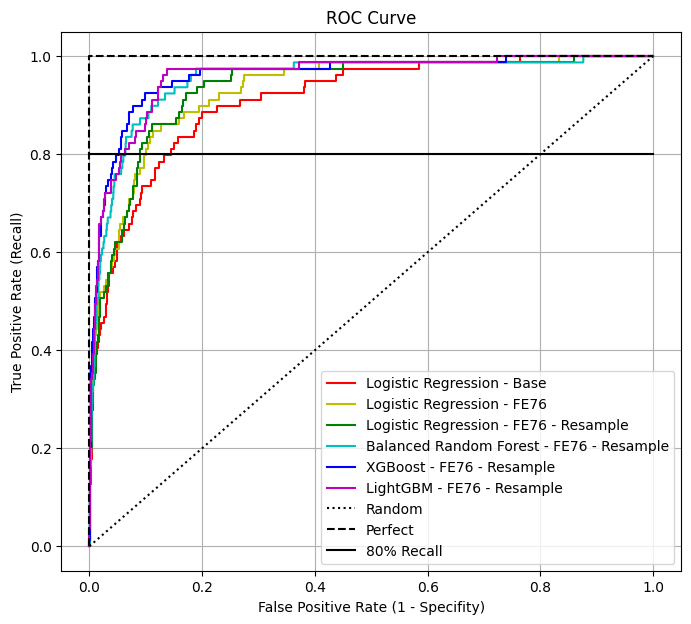

In [117]:
fpr_lr1, tpr_lr1, thr_lr1 = roc_curve(y_test, model_lr_base.predict_proba(Xb_test)[:,1])
fpr_lr2, tpr_lr2, thr_lr2 = roc_curve(y_test, model_lr_fe76.predict_proba(X1_test)[:,1])
fpr_lr3, tpr_lr3, thr_lr3 = roc_curve(y_test, model_lr_fe76_rsmpl.predict_proba(X1_test)[:,1])
fpr_lr4, tpr_lr4, thr_lr4 = roc_curve(y_test, model_rf_fe76_rsmpl.predict_proba(X1_test)[:,1])
fpr_lr5, tpr_lr5, thr_lr5 = roc_curve(y_test, model_xgb_fe76_rsmpl.predict_proba(X1_test)[:,1])
fpr_lr6, tpr_lr6, thr_lr6 = roc_curve(y_test, model_lgb_fe76_rsmpl.predict_proba(X1_test)[:,1])

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot()
plt.plot(fpr_lr1, tpr_lr1, 'r-', label = 'Logistic Regression - Base')
plt.plot(fpr_lr2, tpr_lr2, 'y-', label = 'Logistic Regression - FE76')
plt.plot(fpr_lr3, tpr_lr3, 'g-', label = 'Logistic Regression - FE76 - Resample')
plt.plot(fpr_lr4, tpr_lr4, 'c-', label = 'Balanced Random Forest - FE76 - Resample')
plt.plot(fpr_lr5, tpr_lr5, 'b-', label = 'XGBoost - FE76 - Resample')
plt.plot(fpr_lr6, tpr_lr6, 'm-', label = 'LightGBM - FE76 - Resample')

plt.plot([0,1],[0,1],'k:',label='Random')
plt.plot([0,0,1,1],[0,1,1,1],'k--',label='Perfect')
plt.plot([0,1],[0.8,0.8],'k-',label='80% Recall')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1 - Specifity)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.show()